# Logic-Enhanced Foundation Models (LEFT) in ~ 100 Lines

LEFT is a unified concept learning and reasoning framework that flexibly learns concepts across domains and reasons across unseen tasks.
This notebook demonstrates how to use LEFT to learn and reason about simple shapes in 2D images, with a very small amount of code.

In [1]:
import torch
import jacinle
import numpy as np
import torch.nn as nn
import jactorch

from typing import Optional, Union, List, Dict
from jacinle.config.environ_v2 import configs, set_configs
from left.domain import create_domain_from_parsing
from left.models.model import LeftModel


### Step 1: Load the simple shapes dataset.

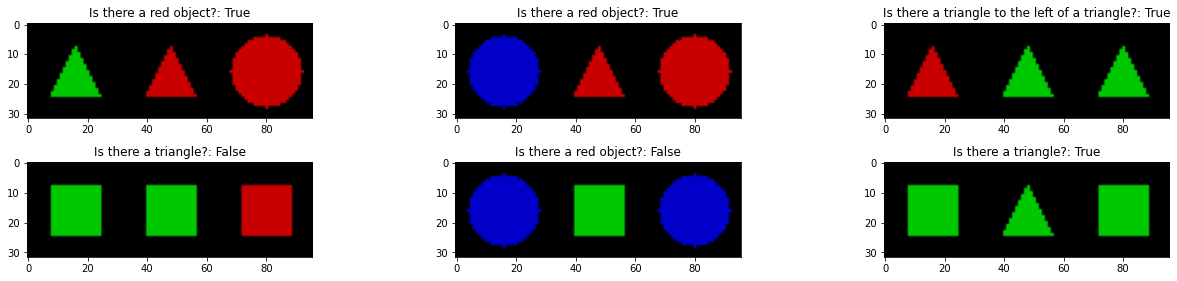

In [2]:
from concepts.benchmark.vision_language.shapes3.dataset import Shapes3Dataset
train_dataset = Shapes3Dataset(dataset_size=1024)  # create a dataset with 1024 samples
test_dataset = Shapes3Dataset(dataset_size=128)  # create a dataset with 128 samples for testing

# Now let's visualize a few samples from the dataset:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 4))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(train_dataset[i]['image'].permute(1, 2, 0).numpy()[..., ::-1] * 0.5 + 0.5)
    plt.title(train_dataset[i]['question'] + ': ' + str(train_dataset[i]['answer']))
plt.tight_layout()
plt.show()

### Step2: Create the model.

Each model in LEFT is composed of:

- a visual feature extract that maps from images to a set of object features and their relational features.
- a concept embedding module that can classify objects and their relations into concepts. In this case, we will use a simple linear layer for all concepts.
- the program executor that takes a FOL program of the question as input, and generate the answer. This part is shared across all tasks, all domains, all modalities.

In [3]:
# Create the visual extractor. In this case, we will assume that we know each image is composed of three objects in a row.
# In general, we can use object detectors to extract the objects from the image.
# For each object, we will extract a 64-dimensional feature vector using a simple CNN.
# For each pair of objects, we will extract another 64-dimensional feature vector,
#   by using a simple lienar mapping from the concatenation of the two object features and their positional embeddings.

class ObjectCentricShapeEmbedding(nn.Module):
    def __init__(self):
        super().__init__()
        self.lenet = nn.Sequential(           # input is 1x32x32
            nn.Conv2d(3, 32, 5), nn.ReLU(),   # conv1: 32x28x28
            nn.MaxPool2d(2, 2),               # pool1: 32x14x14
            nn.Conv2d(32, 32, 5), nn.ReLU(),  # conv2: 32x10x10
            nn.MaxPool2d(2, 2),               # pool2: 32x5x5
        )
        self.fc = nn.Sequential(nn.Linear(32 * 5 * 5, 64), nn.ReLU())
        self.position_embedding = nn.Embedding(9, 64)
        self.fc2 = nn.Linear(256, 64)

    def forward(self, img):
        obj = self.forward_object(img)
        rel = self.forward_relation(obj)
        return obj, rel  # obj: [B, 3, 64], rel: [B, 3, 3, 64]

    def forward_object(self, img):
        # img = B, 3, 30, 30
        b = img.size(0)
        img = img.reshape((b, 3, 1, 32, 3, 32)).permute((0, 2, 4, 1, 3, 5)).reshape((b * 3, 3, 32, 32))
        img = self.lenet(img)
        img = img.reshape((b, 3, 32 * 25))
        img = self.fc(img)
        return img

    def forward_relation(self, object_feat):
        nr_objects = 3
        position_feature = torch.arange(nr_objects, dtype=torch.int64, device=object_feat.device)
        position_feature = self.position_embedding(position_feature)
        position_feature = position_feature.unsqueeze(0).expand(object_feat.size(0), nr_objects, 64)
        feature = torch.cat([object_feat, position_feature], dim=-1)

        feature1 = feature.unsqueeze(1).expand(feature.size(0), nr_objects, nr_objects, 128)
        feature2 = feature.unsqueeze(2).expand(feature.size(0), nr_objects, nr_objects, 128)
        feature = torch.cat([feature1, feature2], dim=-1)

        feature = self.fc2(feature)
        return feature

In [4]:
# Create a main model. You just need to implement the object-centric feature extractor, and a few other lines of code to processs each question in the batch.

with set_configs():
    configs.model.domain = 'shapes3'            # set to the name of the dataset
    configs.model.scene_graph = None            # set to the identifier of the scene graph extractor. In this case we will use our own implementation.
    configs.model.concept_embedding = 'linear'  # set to the identifier of the concept embedding. In this case we will use a simple linear mapping.
    configs.model.sg_dims = [None, 64, 64, 64]  # set to the dimensions of the object and relation features. In this case we will use 64-dimensional features for all of them.


class SimpleShapesModel(LeftModel):
    def __init__(self, domain, parses: Dict[str, Union[str, List[str]]], output_vocab):
        super().__init__(domain, output_vocab)

        self.parses = parses
        self.scene_graph = ObjectCentricShapeEmbedding()

    def forward(self, feed_dict):
        feed_dict = jacinle.GView(feed_dict)
        monitors, outputs = {}, {}

        f_sng = self.forward_sng(feed_dict)
        for i in range(len(feed_dict.question)):
            grounding = self.grounding_cls(f_sng[i], self, self.training, apply_relation_mask=True)
            question = feed_dict.question[i]
            raw_parsing = self.parses[question]
            raw_parsing = raw_parsing[0] if isinstance(raw_parsing, list) else raw_parsing
            # This will write to outputs['executions']
            self.execute_program_from_parsing_string(question, raw_parsing, grounding, outputs)

        update_from_loss_module(monitors, outputs, self.qa_loss(outputs['executions'], feed_dict.answer, question_types=['bool' for _ in outputs['executions']]))

        if self.training:
            loss = monitors['loss/qa']
            return loss, monitors, outputs
        else:
            outputs['monitors'] = monitors
            return outputs

    def forward_sng(self, feed_dict):
        object_features, relation_features = self.scene_graph(feed_dict.image)
        all_scene_features = [{'attribute': object_features[i], 'relation': relation_features[i]} for i in range(len(object_features))]
        return all_scene_features


def update_from_loss_module(monitors, output_dict, loss_update):
    tmp_monitors, tmp_outputs = loss_update
    monitors.update(tmp_monitors)
    output_dict.update(tmp_outputs)

### Step 3: Training and evaluation.

In [5]:
language_to_program = {train_dataset[i]['question']: train_dataset[i]['program'] for i in range(len(train_dataset))}
language_to_program.update({test_dataset[i]['question']: test_dataset[i]['program'] for i in range(len(test_dataset))})

# In this example code, we will not be running GPT to parse the questions. Instead, we just use the groundtruth programs that come with the dataset.
# What you need is simple a dictionary that maps each question to its program.
# Visualize the first 6 questions and their programs.

for i in range(6):
    question = train_dataset[i]['question']
    print(question)
    print(language_to_program[question])

Is there a red object?
exists(Object, lambda x: red(x))
Is there a red object?
exists(Object, lambda x: red(x))
Is there a triangle to the left of a triangle?
exists(Object, lambda x: exists(Object, lambda y: triangle(x) and left(x, y) and triangle(y)))
Is there a triangle?
exists(Object, lambda x: triangle(x))
Is there a red object?
exists(Object, lambda x: red(x))
Is there a triangle?
exists(Object, lambda x: triangle(x))


In [6]:
# Create a domain using all the parsed programs. It will automatically extract all concepts and relations from the programs.
domain = create_domain_from_parsing(language_to_program)

Creating domain from parsings: 100%|##########| 78/78 [00:00<00:00, 13525.54it/s]


In [7]:
# Visualize the domain. You can see that it has extracted all the concepts and relations from the programs.
domain.print_summary()

TypeSystem: Left
  Types:
    Object
    Object_Set
    Action
  Constants:
  Functions:
    equal(#0: int64, #1: int64) -> bool
    greater_than(#0: int64, #1: int64) -> bool
    less_than(#0: int64, #1: int64) -> bool
    red_Object(#0: Object) -> bool
    triangle_Object(#0: Object) -> bool
    left_Object_Object(#0: Object, #1: Object) -> bool
    circle_Object(#0: Object) -> bool
    right_Object_Object(#0: Object, #1: Object) -> bool
    rectangle_Object(#0: Object) -> bool
    blue_Object(#0: Object) -> bool
    green_Object(#0: Object) -> bool


In [8]:
# Define a helper function to update the meters.
def update_meters(meters, monitors, prefix: Optional[str] = None):
    for k in list(monitors.keys()):
        if k + '/n' in monitors:
            meters.update({k: monitors[k]}, n=monitors[k + '/n'], prefix=prefix)
            del monitors[k]
            del monitors[k + '/n']

    meters.update(monitors, prefix=prefix)

# Build the domain.
domain = create_domain_from_parsing(language_to_program)
domain.print_summary()

# Build the model.
model = SimpleShapesModel(domain, language_to_program, output_vocab=None)  # output vocab is not used (Boolean only)

# Build the optimizer.
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-3)
group_meters = jacinle.GroupMeters()

nr_epochs = 8
for i in range(1, nr_epochs + 1):
    dataloader = train_dataset.make_dataloader(batch_size=16, shuffle=True, drop_last=True, nr_workers=0)
    model.train()
    group_meters.reset()
    for data in jacinle.tqdm(dataloader, total=len(dataloader), desc='Epoch {}'.format(i)):
        loss, monitors, outputs = model(data)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        update_meters(group_meters, {k: float(v) for k, v in monitors.items()})
        jacinle.get_current_tqdm().set_description(group_meters.format_simple(f'Epoch {i}', compressed=True))

    # print(group_meters.format_simple(f'Epoch {i}', compressed=False))

    dataloader = test_dataset.make_dataloader(batch_size=16, shuffle=False, drop_last=False, nr_workers=0)
    model.eval()
    group_meters.reset()
    with torch.no_grad():
        for data in jacinle.tqdm(dataloader, total=len(dataloader), desc='Epoch {} (test)'.format(i)):
            outputs = model(data)
            update_meters(group_meters, {k: float(v) for k, v in outputs['monitors'].items()})
            jacinle.get_current_tqdm().set_description(group_meters.format_simple(f'Epoch {i} (test)', compressed=True))

    print(group_meters.format_simple(f'Epoch {i} (test)', compressed=False))

Creating domain from parsings: 100%|##########| 78/78 [00:00<00:00, 16752.30it/s]
18 11:12:02 Function equal automatically registered.
18 11:12:02 Function greater_than automatically registered.
18 11:12:02 Function less_than automatically registered.


TypeSystem: Left
  Types:
    Object
    Object_Set
    Action
  Constants:
  Functions:
    equal(#0: int64, #1: int64) -> bool
    greater_than(#0: int64, #1: int64) -> bool
    less_than(#0: int64, #1: int64) -> bool
    red_Object(#0: Object) -> bool
    triangle_Object(#0: Object) -> bool
    left_Object_Object(#0: Object, #1: Object) -> bool
    circle_Object(#0: Object) -> bool
    right_Object_Object(#0: Object, #1: Object) -> bool
    rectangle_Object(#0: Object) -> bool
    blue_Object(#0: Object) -> bool
    green_Object(#0: Object) -> bool


Epoch 1 acc/qa=0.648438 acc/qa/bool=0.648438 acc/qa_succ_exec=0.648438 acc/success_exec=1.000000 loss/qa=0.563973: 100%|##########| 64/64 [00:07<00:00,  8.16it/s]
Epoch 1 (test) acc/qa=0.726562 acc/qa/bool=0.726562 acc/qa_succ_exec=0.726562 acc/success_exec=1.000000: 100%|##########| 8/8 [00:00<00:00, 56.01it/s]


Epoch 1 (test)
  acc/qa = 0.726562
  acc/qa/bool = 0.726562
  acc/qa_succ_exec = 0.726562
  acc/success_exec = 1.000000


Epoch 2 acc/qa=0.775391 acc/qa/bool=0.775391 acc/qa_succ_exec=0.775391 acc/success_exec=1.000000 loss/qa=0.419515: 100%|##########| 64/64 [00:07<00:00,  8.27it/s]
Epoch 2 (test) acc/qa=0.812500 acc/qa/bool=0.812500 acc/qa_succ_exec=0.812500 acc/success_exec=1.000000: 100%|##########| 8/8 [00:00<00:00, 38.67it/s]


Epoch 2 (test)
  acc/qa = 0.812500
  acc/qa/bool = 0.812500
  acc/qa_succ_exec = 0.812500
  acc/success_exec = 1.000000


Epoch 3 acc/qa=0.834961 acc/qa/bool=0.834961 acc/qa_succ_exec=0.834961 acc/success_exec=1.000000 loss/qa=0.332786: 100%|##########| 64/64 [00:06<00:00,  9.79it/s]
Epoch 3 (test) acc/qa=0.859375 acc/qa/bool=0.859375 acc/qa_succ_exec=0.859375 acc/success_exec=1.000000: 100%|##########| 8/8 [00:00<00:00, 60.29it/s]


Epoch 3 (test)
  acc/qa = 0.859375
  acc/qa/bool = 0.859375
  acc/qa_succ_exec = 0.859375
  acc/success_exec = 1.000000


Epoch 4 acc/qa=0.856445 acc/qa/bool=0.856445 acc/qa_succ_exec=0.856445 acc/success_exec=1.000000 loss/qa=0.275649: 100%|##########| 64/64 [00:05<00:00, 12.08it/s]
Epoch 4 (test) acc/qa=0.875000 acc/qa/bool=0.875000 acc/qa_succ_exec=0.875000 acc/success_exec=1.000000: 100%|##########| 8/8 [00:00<00:00, 45.09it/s]


Epoch 4 (test)
  acc/qa = 0.875000
  acc/qa/bool = 0.875000
  acc/qa_succ_exec = 0.875000
  acc/success_exec = 1.000000


Epoch 5 acc/qa=0.927734 acc/qa/bool=0.927734 acc/qa_succ_exec=0.927734 acc/success_exec=1.000000 loss/qa=0.192131: 100%|##########| 64/64 [00:05<00:00, 12.63it/s]
Epoch 5 (test) acc/qa=0.992188 acc/qa/bool=0.992188 acc/qa_succ_exec=0.992188 acc/success_exec=1.000000: 100%|##########| 8/8 [00:00<00:00, 67.29it/s]


Epoch 5 (test)
  acc/qa = 0.992188
  acc/qa/bool = 0.992188
  acc/qa_succ_exec = 0.992188
  acc/success_exec = 1.000000


Epoch 6 acc/qa=0.985352 acc/qa/bool=0.985352 acc/qa_succ_exec=0.985352 acc/success_exec=1.000000 loss/qa=0.087134: 100%|##########| 64/64 [00:05<00:00, 11.10it/s]
Epoch 6 (test) acc/qa=0.953125 acc/qa/bool=0.953125 acc/qa_succ_exec=0.953125 acc/success_exec=1.000000: 100%|##########| 8/8 [00:00<00:00, 57.58it/s]


Epoch 6 (test)
  acc/qa = 0.953125
  acc/qa/bool = 0.953125
  acc/qa_succ_exec = 0.953125
  acc/success_exec = 1.000000


Epoch 7 acc/qa=0.983398 acc/qa/bool=0.983398 acc/qa_succ_exec=0.983398 acc/success_exec=1.000000 loss/qa=0.076611: 100%|##########| 64/64 [00:07<00:00,  8.69it/s]
Epoch 7 (test) acc/qa=0.992188 acc/qa/bool=0.992188 acc/qa_succ_exec=0.992188 acc/success_exec=1.000000: 100%|##########| 8/8 [00:00<00:00, 47.24it/s]


Epoch 7 (test)
  acc/qa = 0.992188
  acc/qa/bool = 0.992188
  acc/qa_succ_exec = 0.992188
  acc/success_exec = 1.000000


Epoch 8 acc/qa=0.982422 acc/qa/bool=0.982422 acc/qa_succ_exec=0.982422 acc/success_exec=1.000000 loss/qa=0.075972: 100%|##########| 64/64 [00:07<00:00,  9.00it/s]
Epoch 8 (test) acc/qa=0.992188 acc/qa/bool=0.992188 acc/qa_succ_exec=0.992188 acc/success_exec=1.000000: 100%|##########| 8/8 [00:00<00:00, 52.84it/s]

Epoch 8 (test)
  acc/qa = 0.992188
  acc/qa/bool = 0.992188
  acc/qa_succ_exec = 0.992188
  acc/success_exec = 1.000000


### Step 4: Visualize the results.

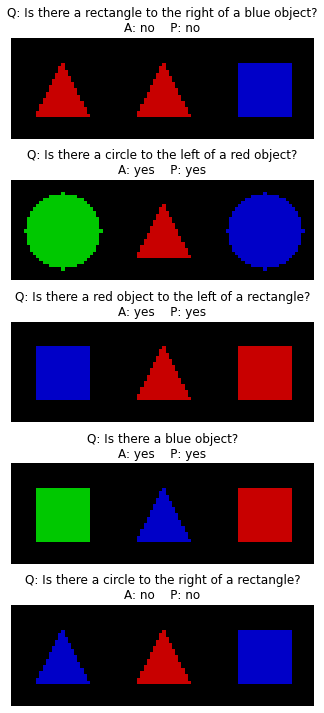

In [9]:
model.eval()

def get_answer(model, image: torch.Tensor, question: str):
    with torch.no_grad():
        outputs = model({'image': image.unsqueeze(0), 'question': [question], 'answer': [None]})
    return outputs['pred_answers'][0]


plt.figure(figsize=(5, 10))
for i in range(5):
    plt.subplot(5, 1, i + 1)
    image, question, answer = test_dataset[i]['image'], test_dataset[i]['question'], test_dataset[i]['answer']
    answer = 'yes' if answer else 'no'
    pred_answer = get_answer(model, image, question)
    plt.imshow(image.permute(1, 2, 0).numpy()[..., ::-1] * 0.5 + 0.5)
    plt.title(f'Q: {question}\nA: {answer}    P: {pred_answer}')
    plt.axis('off')

plt.tight_layout()
plt.show()